# Segment Blood Vessels
by Jeff Benshetler  
## Goal: Segment blood vessel images. 
### Inputs: 
  - Gray scale image from which to segement blood vessels 
  - Regions image, a version of gray scale image with a red boundary identifying the type of region to segment.  

| Image To Segment | Regions Image    |
| ---------------- | ---------------- |
| ![Input Image](input/input.png "Input Image") | ![Reference Image](input/regions.png "Regions Image") | 
### Output:
Gray scale image with white indicating that pixel is categorized as a blood vessel, black otherwise. 

## Approaches
 1. Grabcut segmentation - A defined region of the type of interest suggests that Grabcut could work.
 1. Morphological filtering might work, as this approach is employed with retinal vessels. However, this is more about cleaning up segmentation made from the green/red channels in a color image than crearing an initial segmentation.
 1. Variance filtering, used to compare the variance within the defined region vs. outside. This is a possible approach.
 1. Mutual information - testing for histogram similarity with the histogram of the blocked region

# Preliminaries

## Libraries

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Type hinting

In [2]:
from numpy.typing import NDArray
from typing import List, Tuple

In [3]:
def print_info(name : str, var : NDArray ) -> None:
    print(f"{name}.shape={var.shape} {name}.dtype={var.dtype}")

In [4]:
def show_image(img : NDArray, title : str, dpi : int = 90, colormap : str = 'gray') -> None:
    plt.figure(figsize=(16,9), dpi=dpi)
    _ = plt.imshow(img, colormap)
    _ = plt.title(title) 

In [5]:
def show_images(imgs : List[NDArray], suptitle : str = None, subtitles : list = None, dpi : int = 90):
    """_summary_
    Show 1 or more images in a subplot
    Args:
        imgs (List[NDArray]): _description_ List of images to `plt.imshow`
        suptitle (str, optional): _description_. Defaults to None. Top title, if provided.
        subtitles (list, optional): _description_. Defaults to None. Per-image titles.
        dpi (int, optional): _description_. Defaults to 90. Controls image size. 
    """
    fig = plt.figure(figsize=(16,9), dpi=dpi)
    N = len(imgs)
    for index, img in enumerate(imgs):
        ax = plt.subplot(1,N,index+1)
        if subtitles:
            plt.gca().set_title(subtitles[index])
        plt.imshow(img, 'gray')
    if suptitle is not None:
        fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

In [6]:
def histogram_plot(img : NDArray, title : str = None, dpi : int = 90):
    hist, bins = np.histogram( img.ravel(), bins=256, range=[0,256])
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(bins[:-1], hist / hist.sum())
    if title:
        plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    return bins[:-1], hist

# Inputs

## Read

In [7]:
input_img = cv2.imread('input/input.png')
print_info('input',input_img)

input.shape=(400, 322, 3) input.dtype=uint8


In [8]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
print_info('regions_img',regions_img)

regions_img.shape=(400, 322, 3) regions_img.dtype=uint8


## Preview Inputs

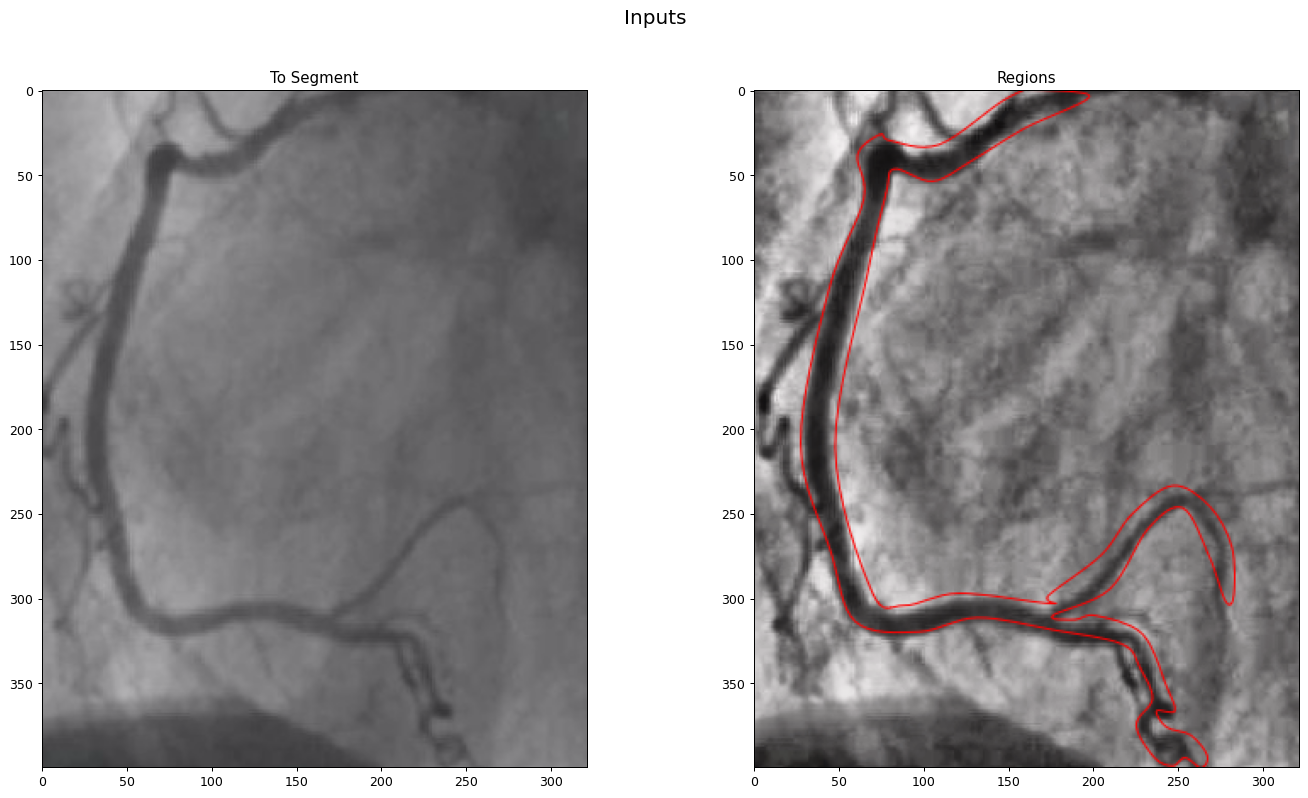

In [9]:
show_images([input_img, regions_img], "Inputs", ["To Segment", "Regions"])

## Equalization

equalized.shape=(400, 322, 3) equalized.dtype=uint8


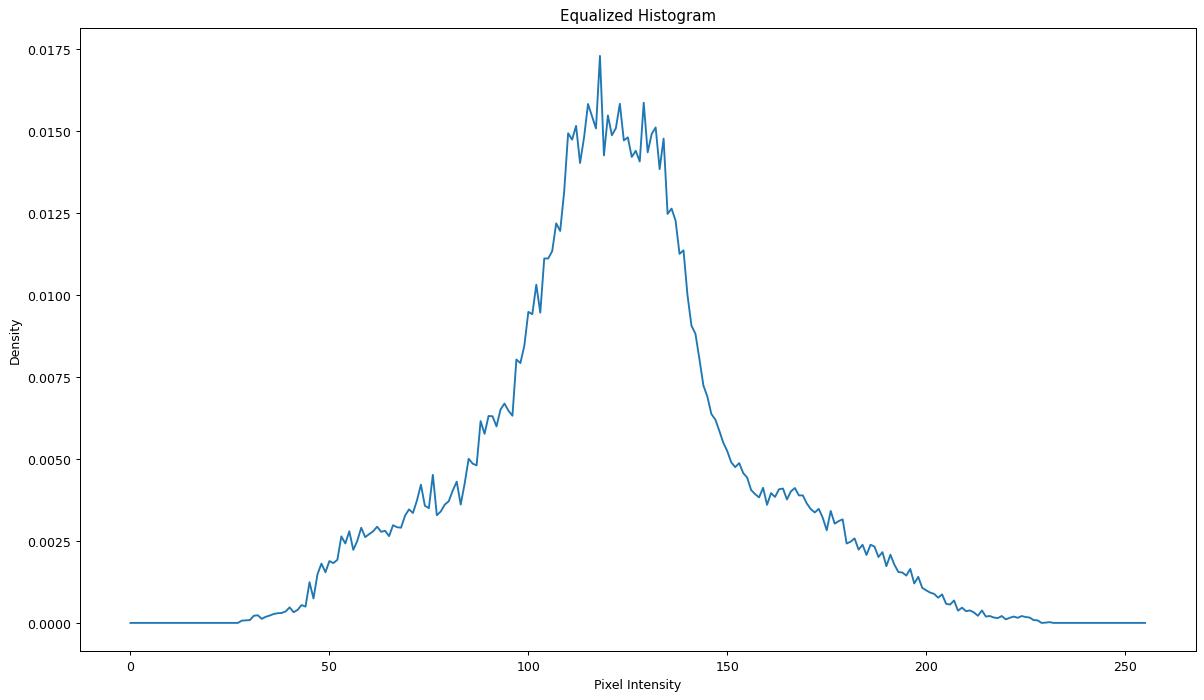

In [10]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized_img = cv2.cvtColor( 
                clahe.apply( 
                    cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) 
                ), 
                cv2.COLOR_GRAY2RGB
            )
print_info('equalized', equalized_img)
_ = histogram_plot(equalized_img[:,:,0], "Equalized Histogram")

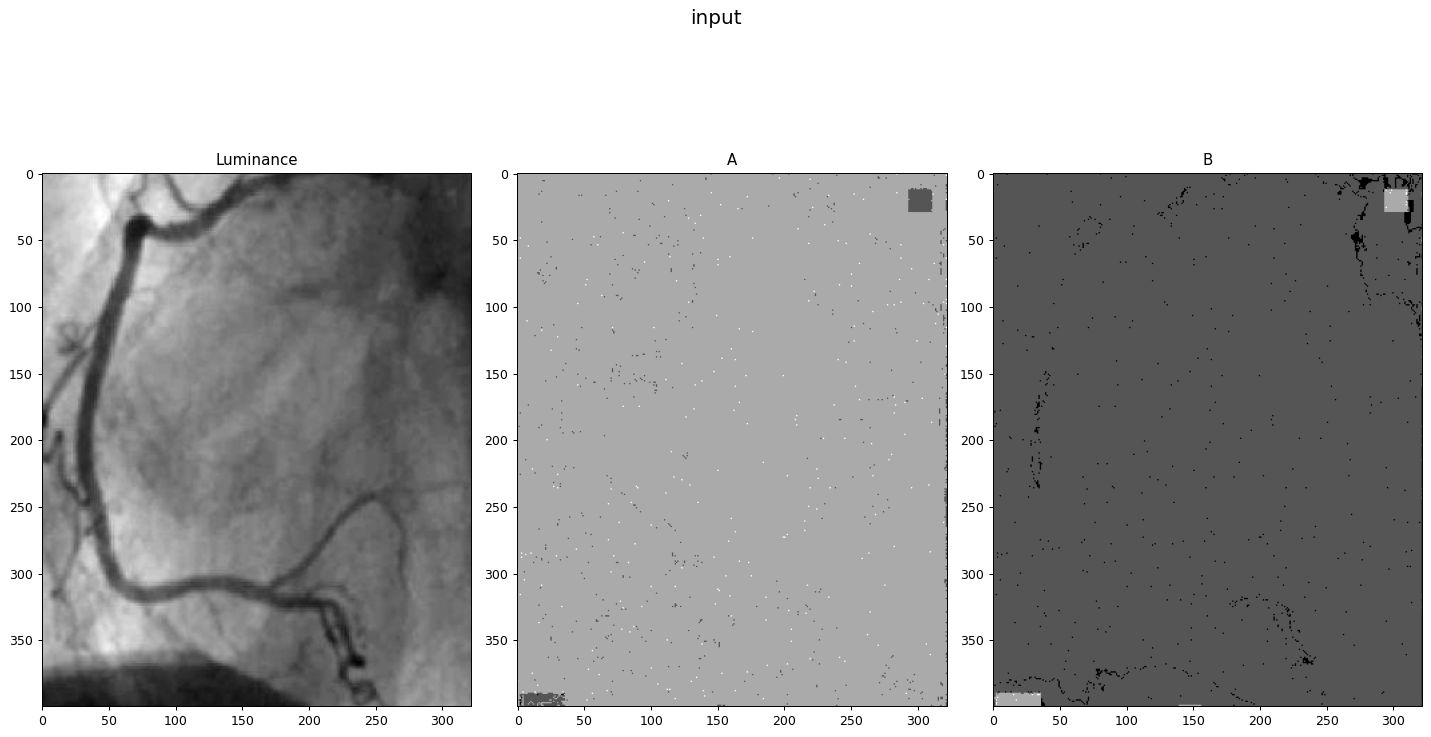

In [11]:
lab = cv2.cvtColor(input_img, cv2.COLOR_BGR2LAB)
l,a,b = cv2.split(lab)
show_images(cv2.split(lab), "input", ["Luminance", "A", "B"] )

# GrabCut Algorithm
The red boundary around an equalized region suggests that [GrabCut](https://www.researchgate.net/publication/220184077_GrabCut_Interactive_Foreground_Extraction_Using_Iterated_Graph_Cuts) segmentation might be appropriate. We need to define seed areas for foreground and background. We will define everything inside the red boundary as probable foreground, and everything else as probable background.  
  
We cannot simply extract the red background via RGB thresholding because the red pixels have been interpolated. Instead, we will work in HSV space. 

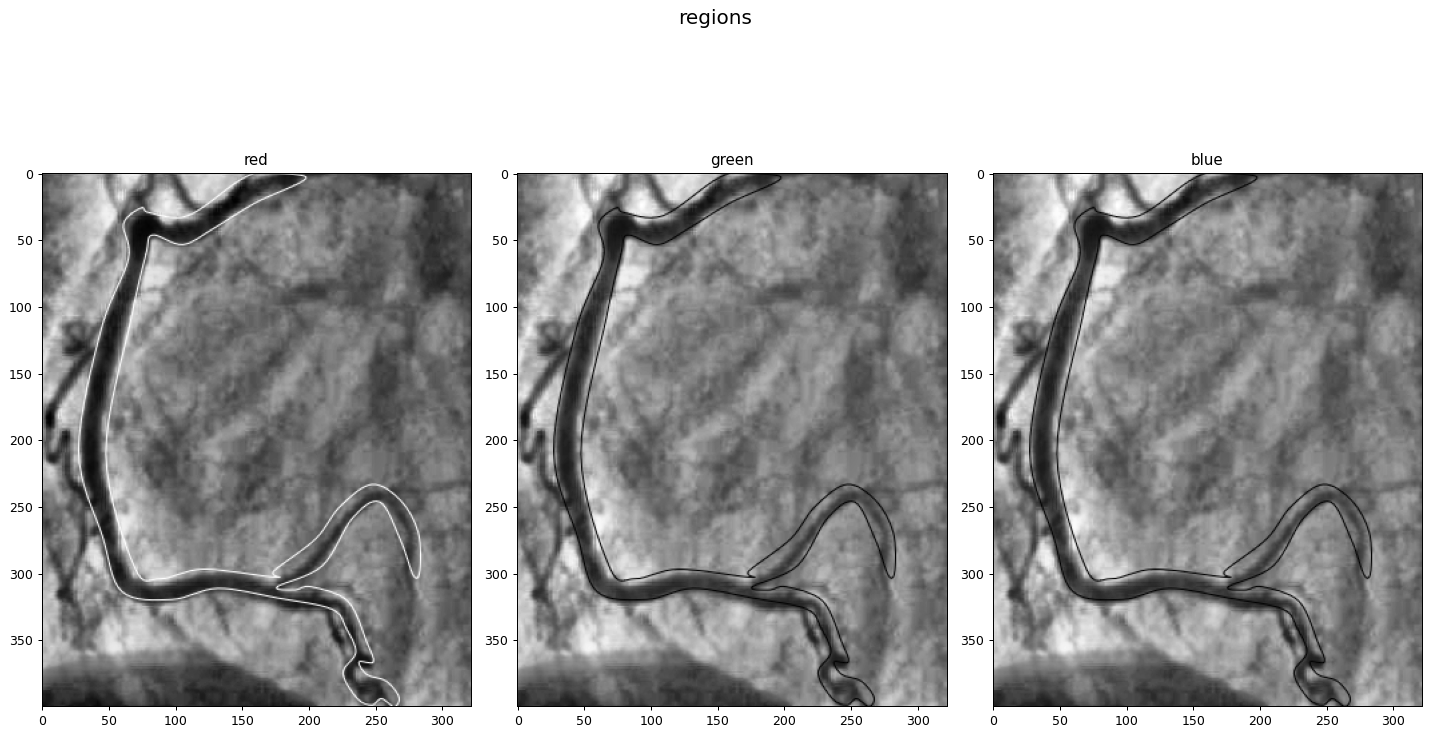

In [12]:
show_images(cv2.split(regions_img), suptitle="regions", subtitles=['red','green','blue'])

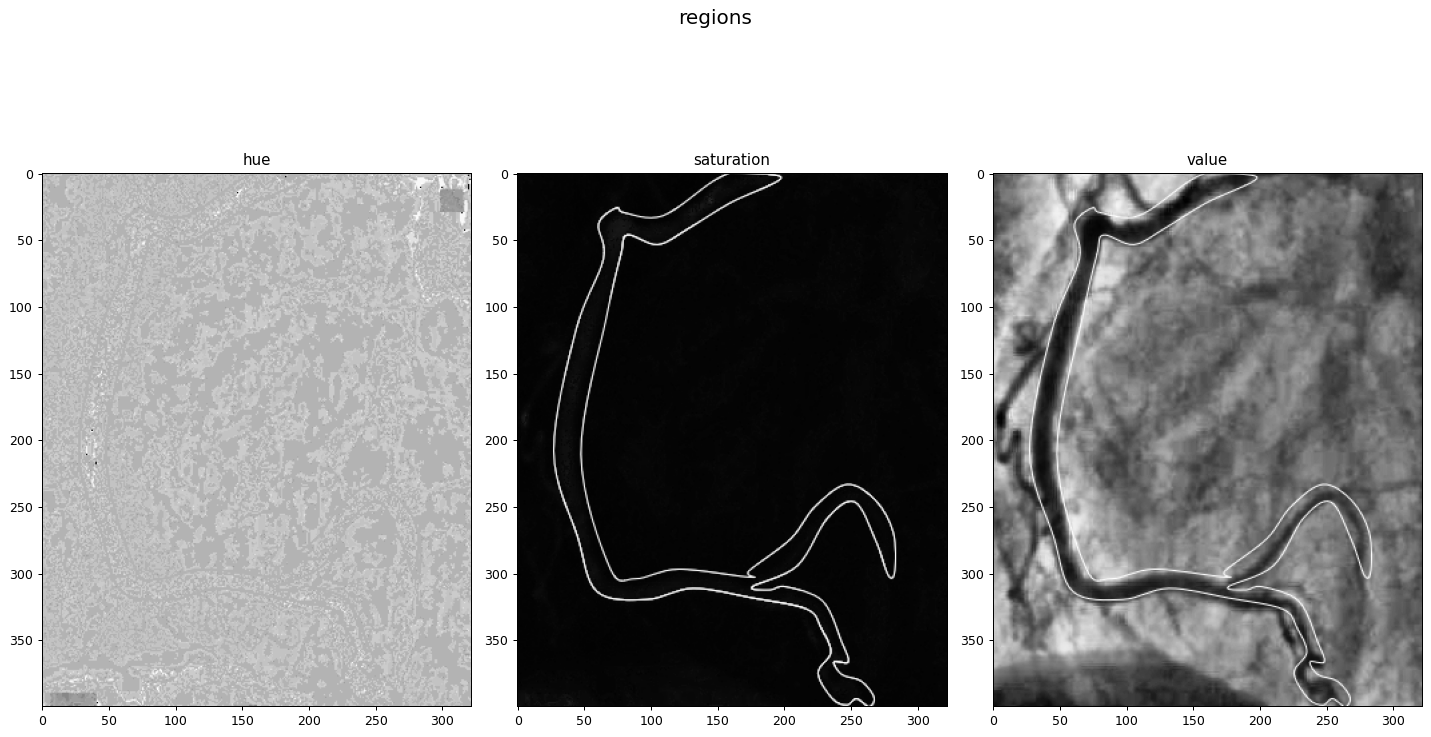

In [13]:
hsv_img = cv2.cvtColor(regions_img, cv2.COLOR_BGR2HSV)
show_images(cv2.split(hsv_img), 'regions', subtitles=['hue', 'saturation', 'value'])

## Find the region boundary contour
There is differentiation in the saturation space. We need to find an appropriate threshold value. 

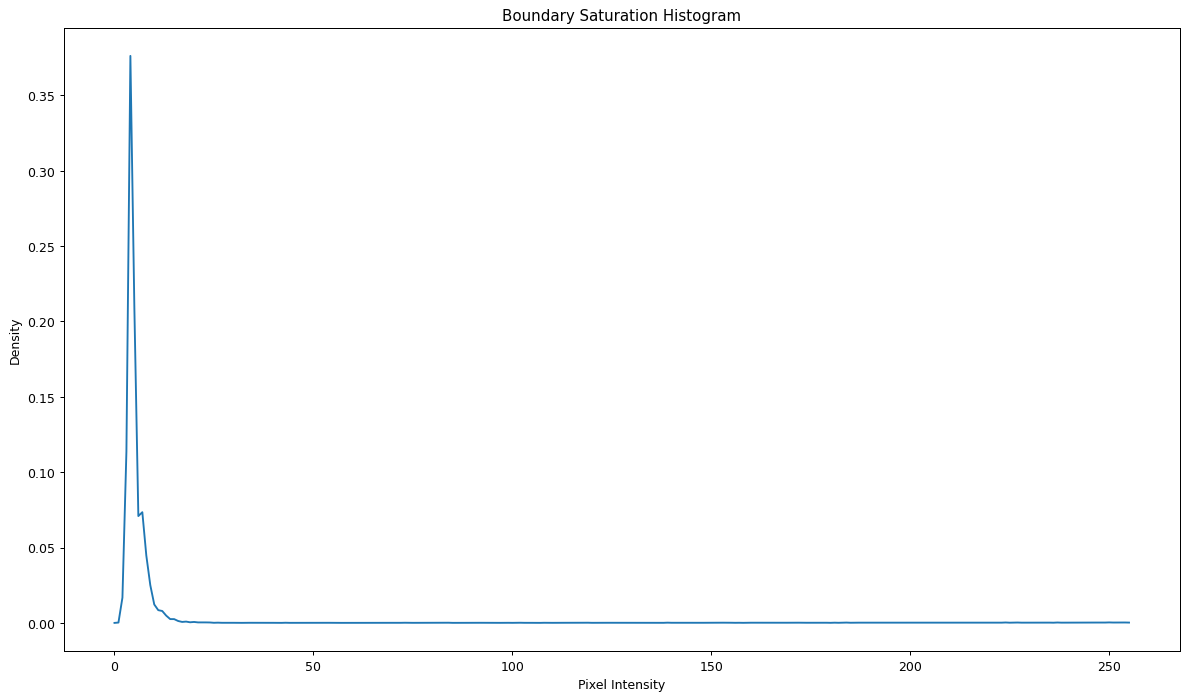

In [14]:
bins, hist = histogram_plot(hsv_img[:,:,1], "Boundary Saturation Histogram")

### Compute threshold level

In [15]:
percentile = 0.98 # empirically derived
bin_index = np.argmax( np.cumsum(hist) >= percentile*np.sum(hist) )
print(f"Bin={bins[bin_index]} meets or exceens percentile={percentile}")

Bin=119.0 meets or exceens percentile=0.98


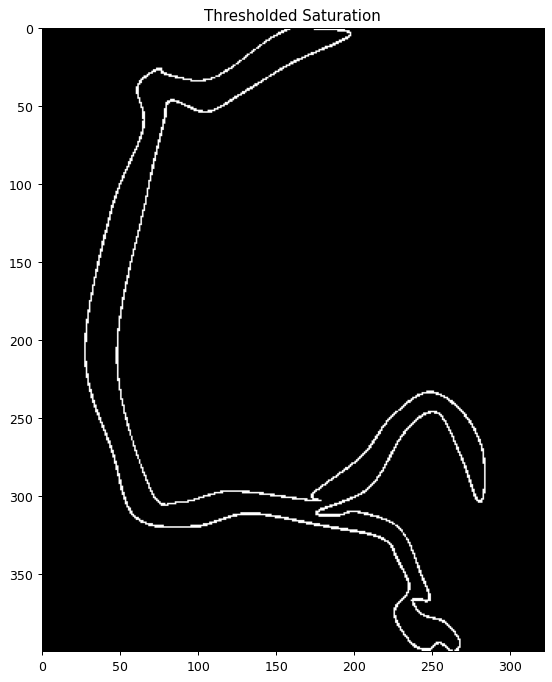

In [16]:
_, saturation_thresholded_img = cv2.threshold(hsv_img[:,:,1], bins[bin_index], 255, cv2.THRESH_BINARY)
show_image(saturation_thresholded_img, "Thresholded Saturation")


## Mask for training
We now convert the threshold to a filled mask for the GrabCut algorithm. 

In [17]:
contours, hierarchy = cv2.findContours(
    image=np.array(saturation_thresholded_img, dtype=np.uint8),
    mode=cv2.RETR_CCOMP,
    method=cv2.CHAIN_APPROX_SIMPLE
)

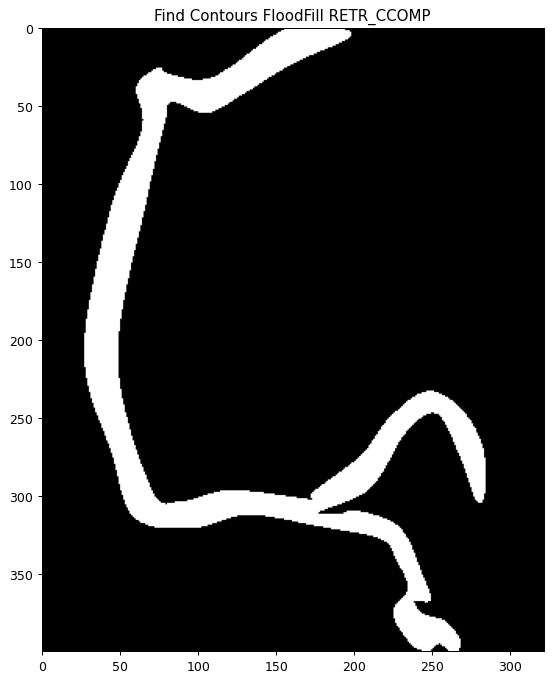

In [18]:
mask = np.zeros(input_img.shape, np.uint8)
contour_img = cv2.drawContours(
    image=mask, 
    contours=contours, 
    contourIdx=-1, 
    color=(255,255,255), 
    thickness=cv2.FILLED
)

#drawContours `cv2.FILLED` is not working, this is a hack
#will find a resolution once we have a working segmentation
cv2.floodFill(contour_img, None, seedPoint=(56,105), newVal=(255,255,255), loDiff=(0,0,0,0), upDiff=(0,0,0,0))

show_image(mask, "Find Contours FloodFill RETR_CCOMP")


# Graphcut Segmentation  
Combining `GC_INIT_WITH_RECT` with `GC_INIT_WITH_MASK`  
https://stackoverflow.com/questions/24629794/opencv-grabcut-how-to-combine-gc-init-with-rect-and-gc-init-with-mask

In [19]:
def graphCutSeg(img : NDArray, roi_mask : NDArray, known_fgd : bool = False, title : str = None):
    plt.figure(figsize=(16,9), dpi=120)
    # plt.subplot(2,3,1)
    # plt.imshow(img)
    
    rows,cols,_ = img.shape
    mask = np.ones((rows,cols), np.uint8) * cv2.GC_PR_BGD
    input_mask = cv2.cvtColor( roi_mask.copy(), cv2.COLOR_RGB2GRAY )
    if known_fgd:
        mask[input_mask>0] = cv2.GC_FGD
    else:
        mask[input_mask>0] = cv2.GC_PR_FGD 

    print_info('img', img)
    print_info('mask', mask)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    x0,y0 = ( int(cols/2),int(rows/2) )
    x1,y1 = ( cols-1, rows-1 )
    rect = (x0, y0, x1-x0, y1-y0)
    iter = 5
    _ =cv2.grabCut(
        img,
        mask,
        rect,
        bgdModel,
        fgdModel,
        iter,
        cv2.GC_INIT_WITH_MASK
    )
    same = np.abs(input_mask - mask)
    changes = np.ones((rows,cols),np.uint8) * 255
    changes[ np.where(input_mask == mask)] = 0
    if title is None:
        title = "Grabcut Segmentation"
    show_images([roi_mask, mask, same], title, ["roi_mask", "segmentation result", "same"])
    

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


<Figure size 1920x1080 with 0 Axes>

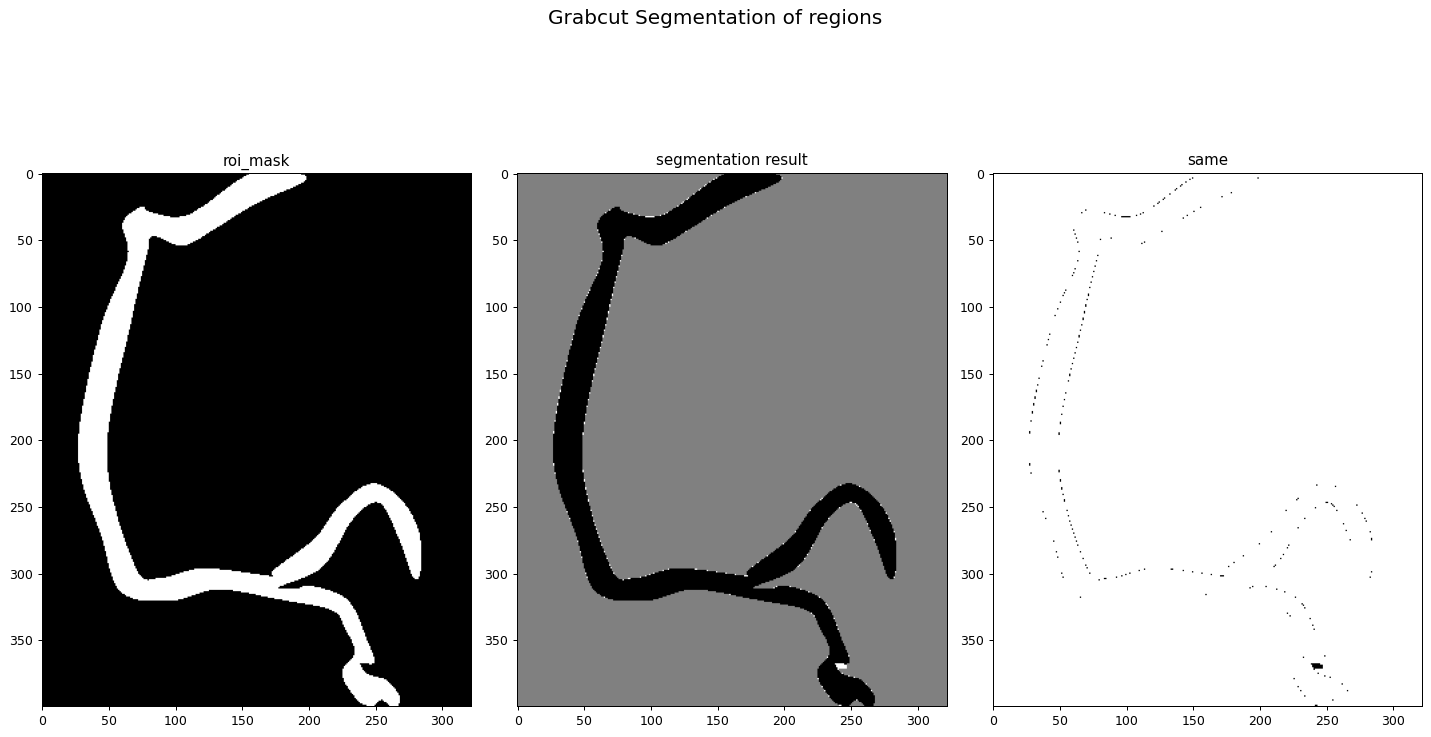

In [20]:
graphCutSeg(regions_img, mask, True, "Grabcut Segmentation of regions")

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


<Figure size 1920x1080 with 0 Axes>

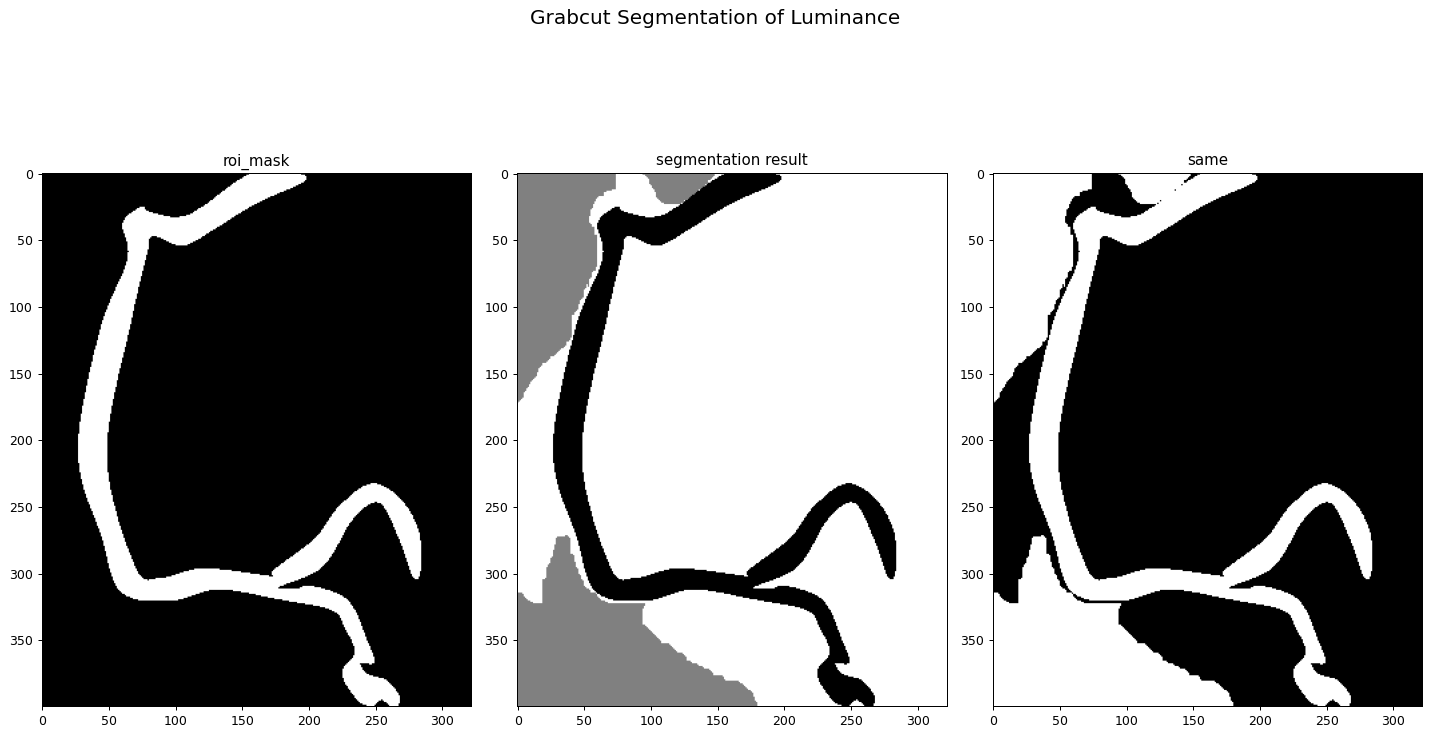

In [21]:
graphCutSeg(cv2.merge([l,l,l]), mask, True, "Grabcut Segmentation of Luminance")

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


<Figure size 1920x1080 with 0 Axes>

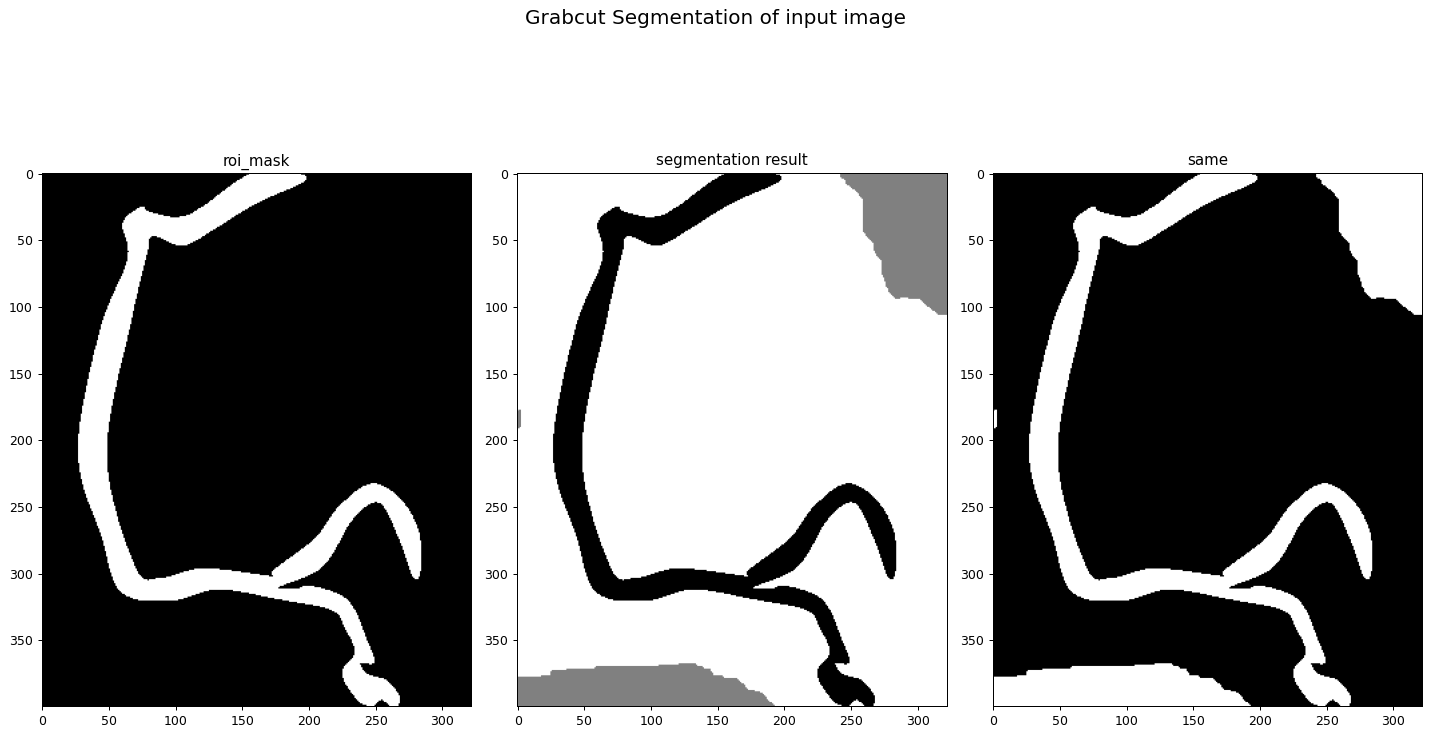

In [22]:
graphCutSeg(input_img, mask, True, "Grabcut Segmentation of input image")

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


<Figure size 1920x1080 with 0 Axes>

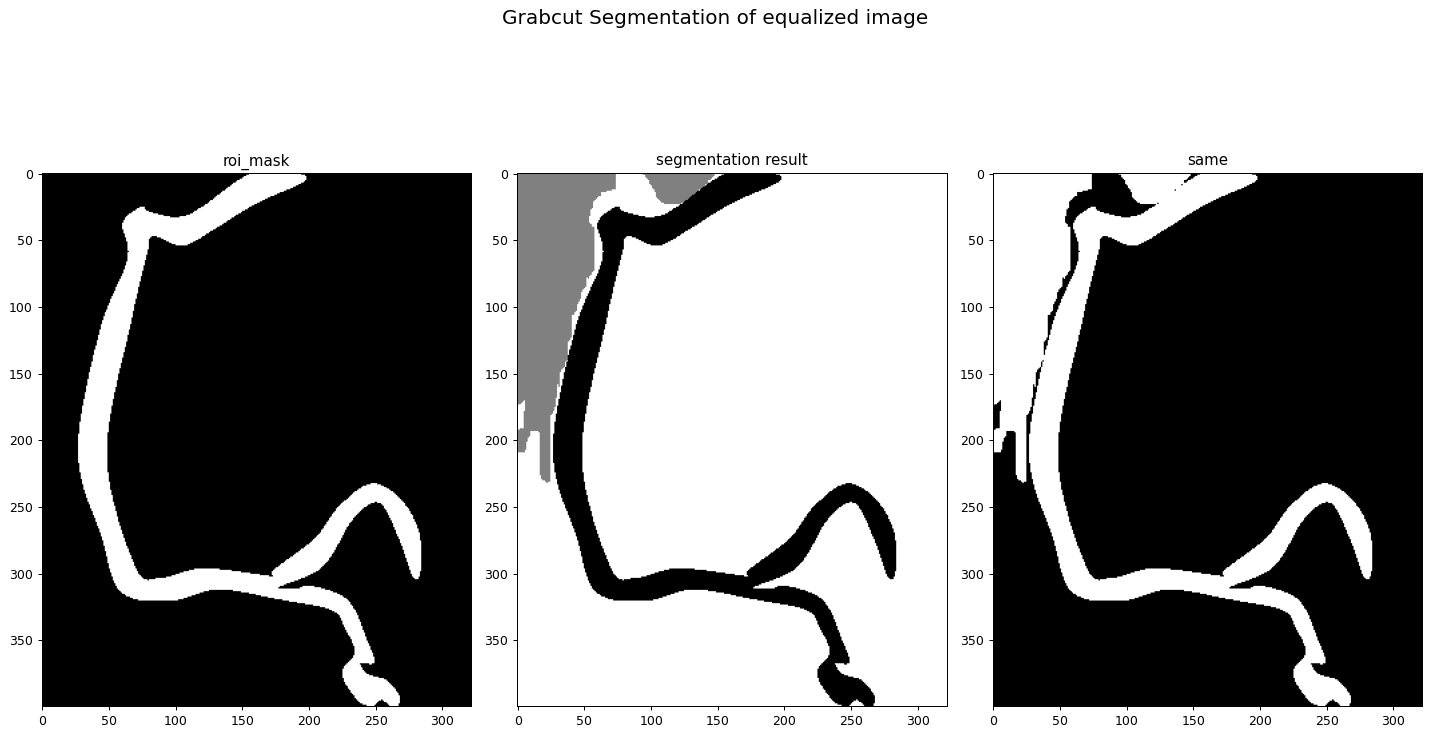

In [23]:
graphCutSeg(equalized_img, mask, True, "Grabcut Segmentation of equalized image")

How to reuse models from grabcut in OpenCV  
https://stackoverflow.com/questions/66476128/how-to-reuse-models-from-grabcut-in-opencv

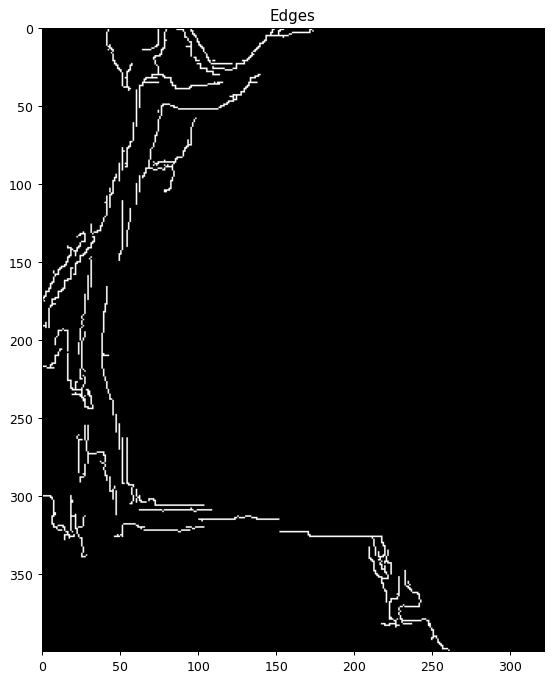

In [24]:
edges_img = np.zeros(equalized_img.shape[:2])
edges_img = cv2.Canny(equalized_img, 50, 180, edges_img, apertureSize=3, L2gradient=True)
show_image(edges_img, "Edges")

# plt.figure(figsize=(16,9),dpi=120)
# plt.imshow(edges_img,'gray')

# Ideas
+ Mutual Information
+ Local variance https://stackoverflow.com/questions/66975708/sliding-window-on-an-image-to-calculate-variance-of-pixels-in-that-window
+ Morphology
+ floodfill with boundaries set by MI


In [25]:
def sobel(img : NDArray) -> NDArray:
    """_summary_
    Compute edge strength image
    Args:
        img (NDArray): _description_

    Returns:
        NDArray: _description_
    """
    ddepth = cv2.CV_16S
    scale = 1
    delta = 0
    ksize = 3
    grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)


    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

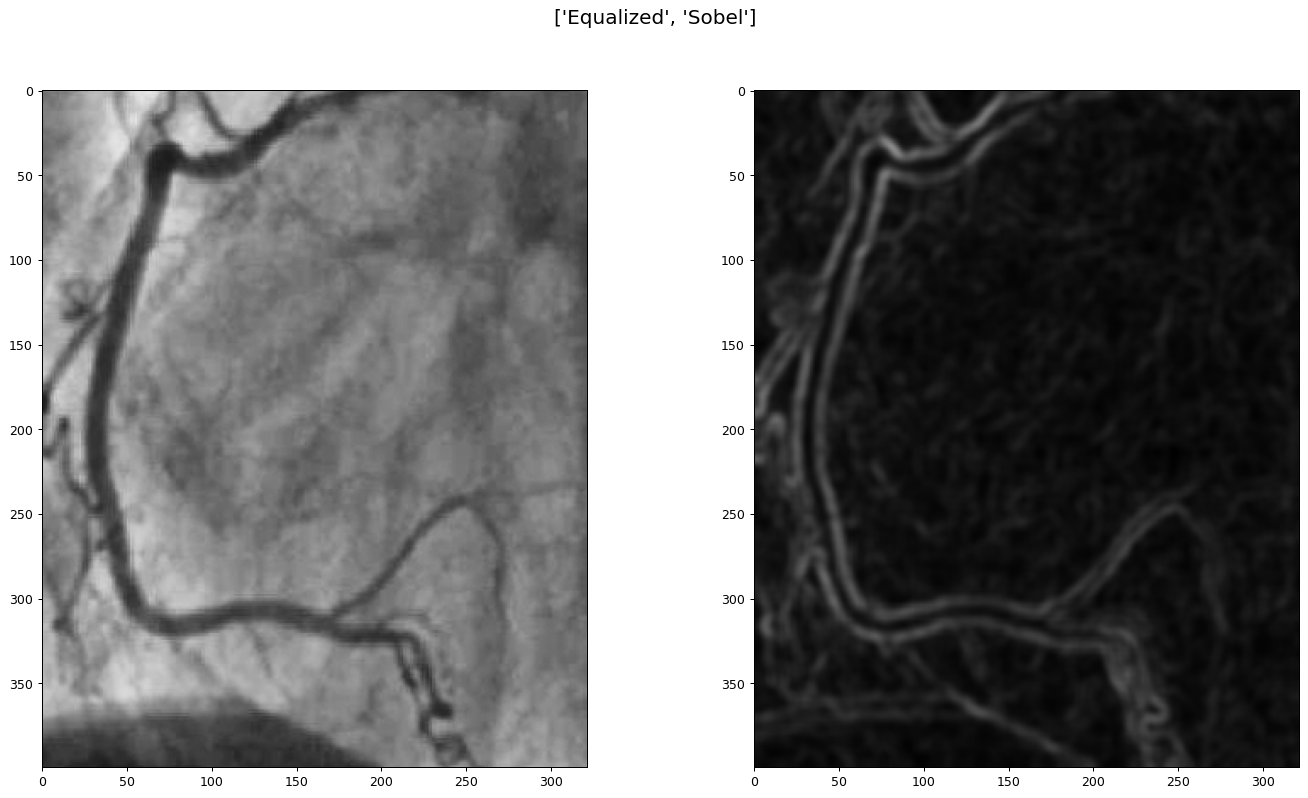

In [26]:
sobel_img = cv2.GaussianBlur( sobel( equalized_img ) ,(7,7), 3.0) 
show_images([equalized_img, sobel_img], ["Equalized", "Sobel"])
# plt.figure(figsize=(16,9), dpi=120)
# plt.subplot(1,2,1)
# plt.imshow(grad, 'gray')
# plt.subplot(1,2,2)
# plt.imshow(equalized, 'gray')
# plt.show()

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


<Figure size 1920x1080 with 0 Axes>

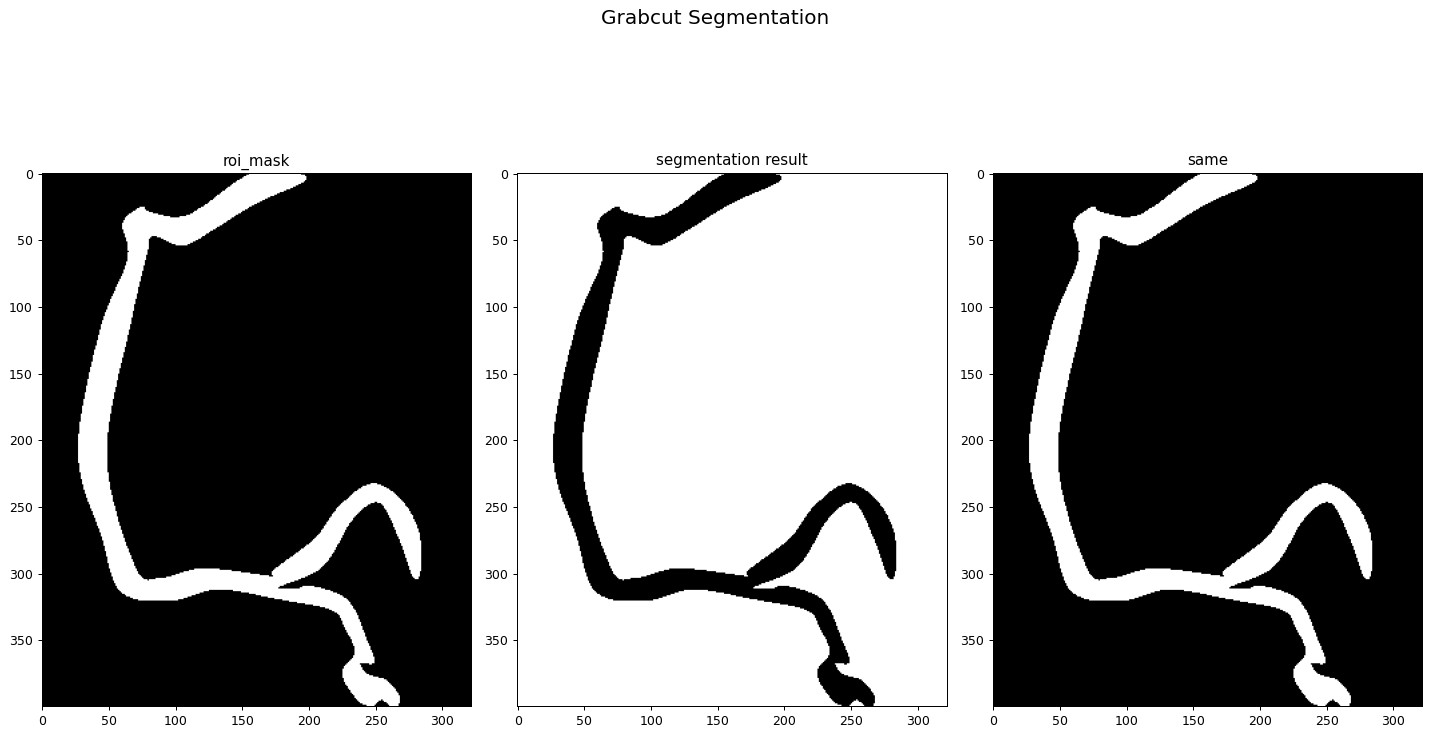

In [27]:
graphCutSeg(sobel_img.astype(np.uint8), mask, True)

# Morphology
Can we segment the vessels using structuring operations? This is a challenge, because we do not have strong FG/BG segmentation like we can get using multiple color channels in a retinal image.

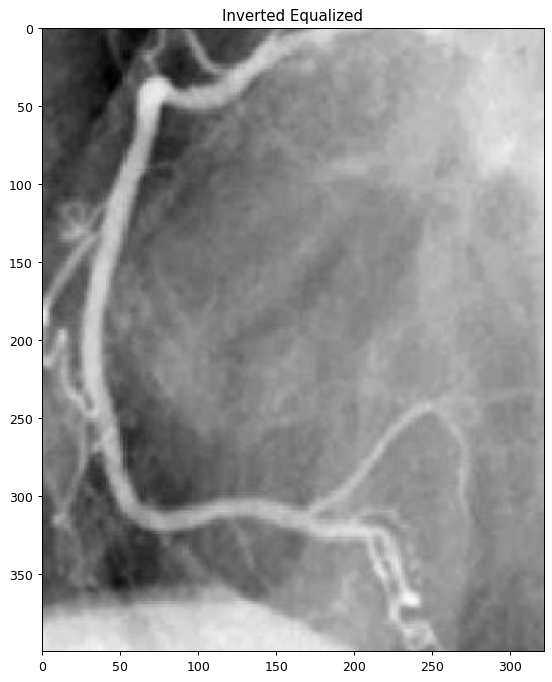

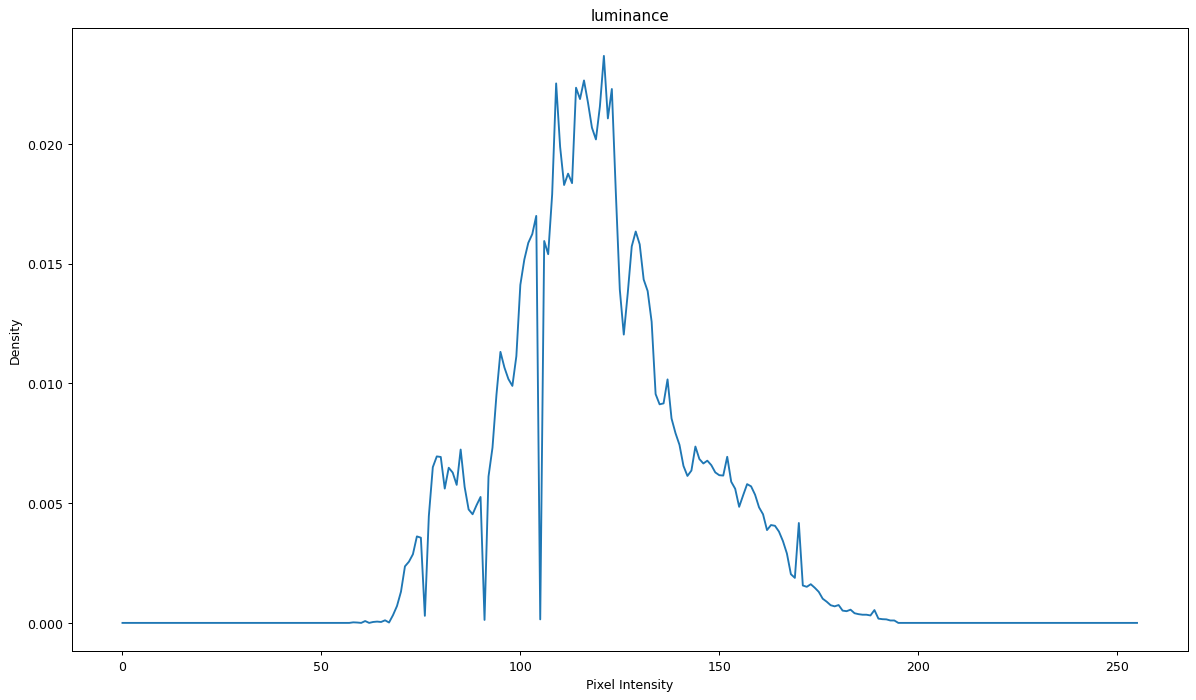

In [36]:
negative_img = cv2.bitwise_not(l)
show_image(negative_img, "Inverted Equalized")
_ =histogram_plot(l, "luminance")

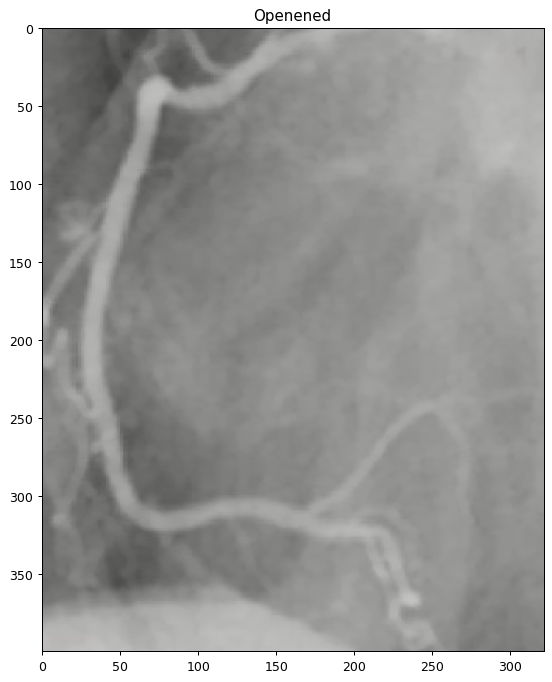

In [29]:
r1 = cv2.morphologyEx(negative_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,3)), iterations = 1)
show_image(r1, "Openened")

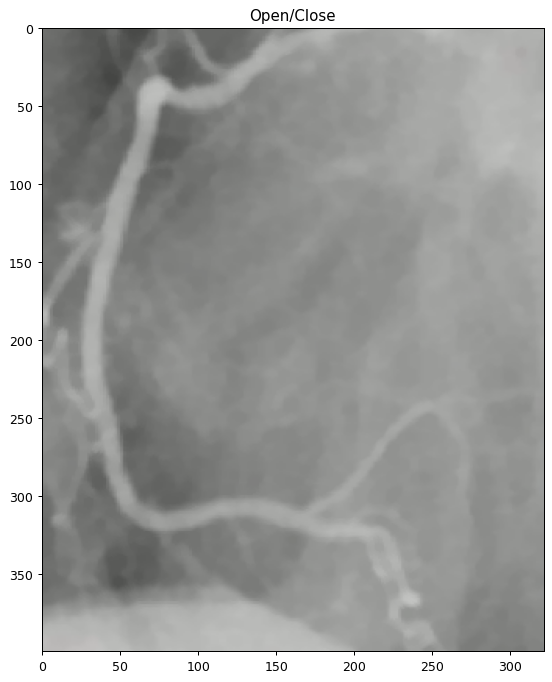

In [30]:
r2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
show_image(r2, "Open/Close")